In [2]:
import re
import csv
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import pickle

In [20]:
os.getcwd()

'C:\\Users\\Asus\\Desktop\\Project\\ImageRecommender'

In [8]:
# Counter for unique image names
image_counter = 0

# we should make another generator to rename the images, so that only the rename generator run once, and then we can run the generator files to get the filepath multiple times

# creating the generator
def reader(filepath, rename=False):
    '''
    This function generates through all the images file in the folder
    ''' 
    current_path = filepath 
    print(current_path)
    
    global image_counter  
    
    for foldername in os.listdir(current_path):
        folderpath = os.path.join(filepath, foldername)
        current_path = folderpath
        
        if os.path.isdir(folderpath) and not foldername.startswith('.'):
            os.chdir(folderpath)
            print(folderpath)
            
            for file in os.listdir(folderpath):
                if file.endswith(".jpg") or file.endswith(".png"): 
                    with open(os.path.join(folderpath, file), "rb") as f:
                        image = f.read()
                        img = cv2.imread(file)
                    
                    # check if image can be loaded correctly
                    if img is not None:   
                        #create new name
                        unique_id = f"{image_counter:07}_"
                        
                        image_counter += 1
                        
                        # yield tuple, so later we need to use
                        yield (unique_id, img, os.path.join(folderpath, file))
                        
                    else:
                        # check path or image format
                        print(f"Error while loading image: {file}")
            
            os.chdir('..')

In [13]:
def get_colour_hist(image):
    
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Calculate colour histogram
    red_hist = cv2.calcHist([red_channel], [0], None, [30], [0, 256])
    green_hist = cv2.calcHist([green_channel], [0], None, [30], [0, 256])
    blue_hist = cv2.calcHist([blue_channel], [0], None, [30], [0, 256])

    # Normalize the colour histogram value
    red_hist = cv2.normalize(red_hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    green_hist = cv2.normalize(green_hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    blue_hist = cv2.normalize(blue_hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    return red_hist, green_hist, blue_hist

In [21]:
filepath = os.path.join(os.getcwd(), "weather_image_recognition")
gen = reader(filepath)

In [22]:
# change to `filepath` for creating the csv there
os.chdir(filepath)

In [23]:
# Counter for unique image names
image_counter = 0
gen = reader(filepath) # get histogram values

master_df = pd.DataFrame()
# LOOP OVER ALL IMAGES

for index, image, file_path in tqdm_notebook(gen, desc="extracting RGB information from the images"): # tqdm for terminal 
    #file_name = os.path.basename(file_path).replace(".jpg", "").replace(".png", "") # extract the filename
    rgb_array = get_colour_hist(image)
    
    # extract and format the color values
    red_channel = rgb_array[0]
    green_channel = rgb_array[1]
    blue_channel = rgb_array[2]
   
    # merged the list from RGB channel into one list
    merged_list = np.concatenate((red_channel, green_channel, blue_channel), axis=1).flatten().tolist()
    
    # create a DataFrame, tranpose it, add id and merge to master_df
    df = pd.DataFrame(merged_list)
    df = df.transpose()
    df["image_id"] = index
    df["file_path"] = file_path
    df = df.set_index('image_id')
    
    master_df = pd.concat([master_df, df])

# split the path from the color historgram
path_df = master_df[["file_path"]]
color_df = master_df.drop("file_path", axis="columns")

# save to csv
path_df.to_csv('file_path.csv')
color_df.to_csv('color_histogram.csv')

extracting RGB information from the images: 0it [00:00, ?it/s]

C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\dew
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\fogsmog
Error while loading image: 4514.jpg
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\frost
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\glaze
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\hail
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\lightning
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\rain
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\rainbow
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\rime
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\sandstorm
C:\Users\Asus\Desktop\Project\ImageRecommender\weather_image_recognition\snow
Error while load

### check csv

In [25]:
data = pd.read_csv('color_histogram.csv', index_col='image_id')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
image_id,,,,,,,,,,,,,,,,,,,,,
0000000_,1.000000e+00,8.741844e-02,7.034527e-01,0.011057,0.052840,0.601915,0.003207,0.083466,0.649100,0.002313,...,0.000042,0.000013,1.406734e-03,-1.437002e-10,0.000104,5.275069e-11,0.001708,0.001584,0.028443,0.021604
0000001_,-1.455192e-11,-1.637090e-11,-1.045919e-11,0.002393,0.005573,0.001429,0.007051,0.017359,0.005110,0.021533,...,0.406501,0.389849,6.174161e-01,4.125379e-01,0.542714,8.710924e-01,0.555396,1.000000,1.000000,1.000000
0000002_,1.448514e-01,6.331907e-04,1.521892e-02,0.830019,0.188652,0.400394,1.000000,0.317324,1.000000,0.488636,...,0.000183,0.000000,3.637979e-12,1.830213e-04,0.000039,3.637979e-12,0.000070,0.000039,0.000134,0.000000
0000003_,0.000000e+00,6.572029e-05,0.000000e+00,0.004035,0.008215,0.003885,0.026543,0.050210,0.028661,0.162033,...,0.010127,0.007377,2.563091e-03,4.267244e-03,0.002207,1.182965e-03,0.001465,0.001135,0.000000,0.000764
0000004_,1.967518e-03,0.000000e+00,0.000000e+00,0.002468,0.000000,0.000074,0.002504,0.000000,0.000628,0.007691,...,0.003619,0.004865,1.007302e-02,1.403405e-03,0.003470,4.596427e-03,0.001108,0.000000,0.002347,0.000222


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31932 entries, 0000000_ to 0031931_
Data columns (total 90 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       31932 non-null  float64
 1   1       31932 non-null  float64
 2   2       31932 non-null  float64
 3   3       31932 non-null  float64
 4   4       31932 non-null  float64
 5   5       31932 non-null  float64
 6   6       31932 non-null  float64
 7   7       31932 non-null  float64
 8   8       31932 non-null  float64
 9   9       31932 non-null  float64
 10  10      31932 non-null  float64
 11  11      31932 non-null  float64
 12  12      31932 non-null  float64
 13  13      31932 non-null  float64
 14  14      31932 non-null  float64
 15  15      31932 non-null  float64
 16  16      31932 non-null  float64
 17  17      31932 non-null  float64
 18  18      31932 non-null  float64
 19  19      31932 non-null  float64
 20  20      31932 non-null  float64
 21  21      31932 non-null  float6

In [11]:
data.index

Index(['0000000_', '0000001_', '0000002_', '0000003_', '0000004_', '0000005_',
       '0000006_', '0000007_', '0000008_', '0000009_',
       ...
       '0031922_', '0031923_', '0031924_', '0031925_', '0031926_', '0031927_',
       '0031928_', '0031929_', '0031930_', '0031931_'],
      dtype='object', name='image_id', length=31932)

In [14]:
data.loc['0000000_']

0                                                          1.0
1                                                     0.087418
2                                                     0.703453
3                                                     0.011057
4                                                      0.05284
                                   ...                        
86                                                    0.001708
87                                                    0.001584
88                                                    0.028443
89                                                    0.021604
file_path    C:\Users\Asus\Desktop\Project\ImageRecommender...
Name: 0000000_, Length: 91, dtype: object

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

arr_euc = np.array([])
for i in range(len(data)):
    v1 = np.array(data.iloc[8500, :-1])
    v2 = np.array(data.iloc[i, :-1])
    arr_euc = np.append(arr_euc, distance.euclidean(v1, v2))

sorted_indices_euc = np.argsort(arr_euc)
print(sorted_indices_euc[:5])

[ 8500  9028 20719  7535 14230]


In [16]:
arr_cos = np.array([])

for i in range(len(data)):
    v1 = np.array(data.iloc[-1, :-1].values).reshape(1, -1)
    v2 = np.array(data.iloc[i, :-1].values).reshape(1, -1)
    arr_cos = np.append(arr_cos, cosine_similarity(v1, v2))

sorted_indices_cos = np.argsort(arr_cos)
print(sorted_indices_cos[-5:])

[ 3582 10082 18365 20182 31931]


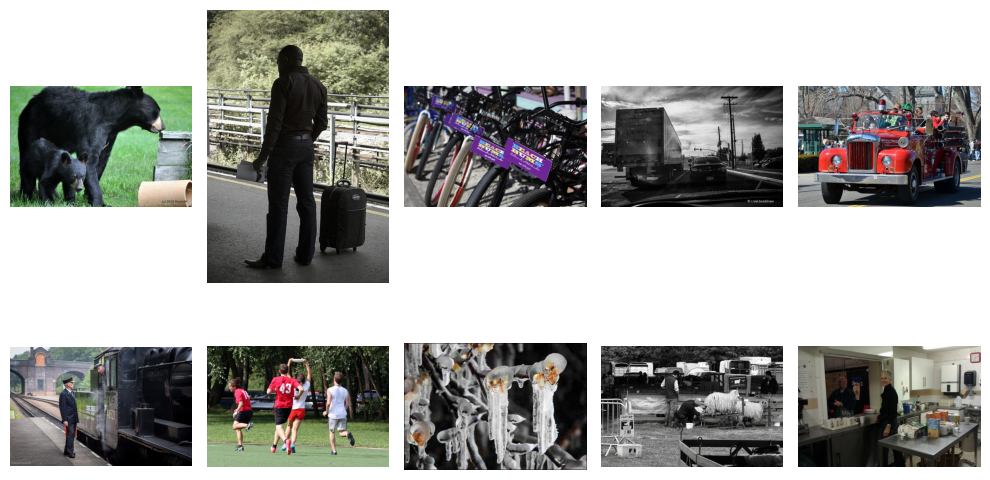

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

top_5_euc = sorted_indices_euc[:10]
#bottom_5_cos = sorted_indices_cos[-10:]
def plot_images(file_paths):
    num_images = len(file_paths)
    num_rows = 2
    num_cols = (num_images + 1) // 2  # Calculate the number of columns based on the number of images

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            try:
                img = mpimg.imread(file_paths[i])
                ax.imshow(img)
                ax.axis('off')
            except IOError:
                print(f"Unable to open image file: {file_paths[i]}")
        else:
            ax.axis('off')  # Hide unused subplot

    plt.tight_layout()
    plt.show()

# Usage example
file_paths = []
for i in top_5_euc:
#for i in bottom_5_cos:
    idx = f"{i:07}_"
    img_path = data.loc[idx]["file_path"]
    file_paths.append(img_path)
    
#file_paths = sorted_indices_euc
plot_images(file_paths)

In [67]:
idx

'013841_'